In [2]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from fashion_model import FashionCNN 
from manifold_sampling import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
EXPERIMENT = "mnist"
PERTURBATION_STD = 0.01
NUM_PERTURBATIONS = 100
MULTIPLIER = 100
DIM = 2
PIVOTS = 10
SHUFFLE = False
TRAIN_RATIO = 0.5

print("EXPERIMENT: ", EXPERIMENT)
print("MULTIPLIER: ", MULTIPLIER)
print("PERTURBATION_STD: ", PERTURBATION_STD)
print("DIM: ", DIM)
print("PIVOTS: ", PIVOTS)
print("SHUFFLE: ", SHUFFLE)

EXPERIMENT:  mnist
MULTIPLIER:  100
PERTURBATION_STD:  0.01
DIM:  2
PIVOTS:  10
SHUFFLE:  False


In [4]:
if EXPERIMENT == 'fashion_mnist':
    print("Loading fashion mnist")
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    print("Loading mnist")
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))

start_time = time.time()
manifold_sampler = Manifold_Image_Sampler(all_images, dim = DIM, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)

Loading mnist
Done loading
Initialize duration:  165.23210215568542


In [5]:
start_time = time.time()
manifold_sampler.train_multiplier = MULTIPLIER
manifold_sampler.std_train = PERTURBATION_STD
manifold_sampler.train_pivot(no_pivots_per_label = PIVOTS, shuffle = SHUFFLE)
duration = time.time() - start_time
print("Train duration: ", duration)

def get_discriminator(X,y,n_estimators = 100, train_ratio = 0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - train_ratio)
    the_rf = RandomForestClassifier(n_estimators=n_estimators).fit(X_train, y_train)
    y_pred = the_rf.predict(X_test)
    the_rf_result = (y_pred == y_test).sum()
    return the_rf, the_rf_result/y_test.shape[0], X_train.shape[0]

def get_discriminator_performance(X,y,rf):
    y_pred = rf.predict(X)
    the_rf_result = (y_pred == y).sum()
    return the_rf_result/y.shape[0], y.shape[0]

X_in = manifold_sampler.pivots.numpy()
X_per = np.expand_dims(np.vstack([perturbs[0] for perturbs in manifold_sampler.perturbs]), axis = 1)
X_plane = np.zeros_like(X_in)
X_ortho = np.zeros_like(X_in)
for i in range(X_plane.shape[0]):
    X_plane[i] = manifold_sampler.pivots[i] + manifold_sampler.plane_noise[i][0]
    X_ortho[i] = manifold_sampler.pivots[i] + manifold_sampler.ortho_noise[i][0]

Train duration:  188.2118637561798


In [19]:
t = 1

X_in = manifold_sampler.pivots.numpy()
X_per = np.expand_dims(np.vstack([perturbs[t] for perturbs in manifold_sampler.perturbs]), axis = 1)
X_plane = np.zeros_like(X_in)
X_ortho = np.zeros_like(X_in)
for i in range(X_plane.shape[0]):
    X_plane[i] = manifold_sampler.pivots[i] + manifold_sampler.plane_noise[i][t]
    X_ortho[i] = manifold_sampler.pivots[i] + manifold_sampler.ortho_noise[i][t]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


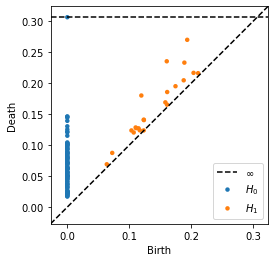

In [6]:
from ripser import Rips

rips = Rips()
data = np.random.random((100,2))
diagrams = rips.fit_transform(data)
rips.plot(diagrams)

In [20]:
print(X_in.shape)
print(X_per.shape)
print(X_plane.shape)
print(X_ortho.shape)

(100, 1, 28, 28)
(100, 1, 28, 28)
(100, 1, 28, 28)
(100, 1, 28, 28)


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


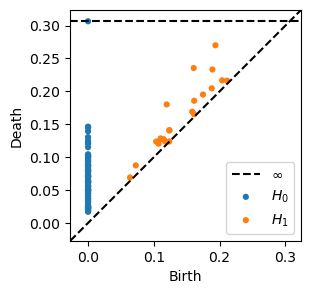

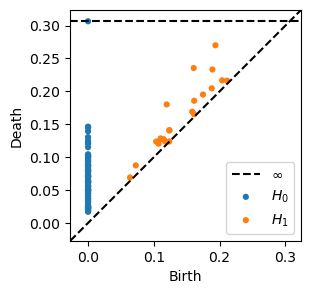

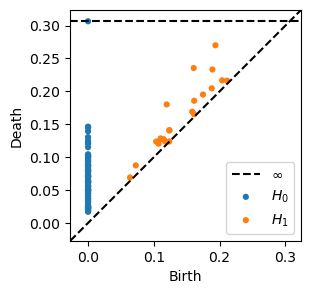

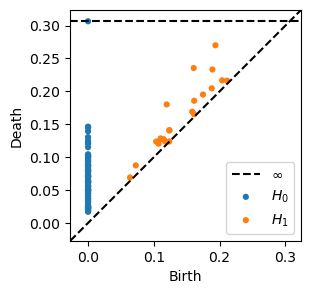

In [21]:
rips = Rips()
diagrams_in = rips.fit_transform(manifold_sampler.transform(X_in))
plt.figure(figsize = (3,3))
rips.plot(diagrams)

diagrams_per = rips.fit_transform(manifold_sampler.transform(X_per))
plt.figure(figsize = (3,3))
rips.plot(diagrams)

diagrams_plane = rips.fit_transform(manifold_sampler.transform(X_plane))
plt.figure(figsize = (3,3))
rips.plot(diagrams)

diagrams_ortho = rips.fit_transform(manifold_sampler.transform(X_ortho))
plt.figure(figsize = (3,3))
rips.plot(diagrams)

In [9]:
from persim import plot_diagrams, bottleneck

In [22]:
for i in [0,1]:
    print(bottleneck(diagrams_in[i], diagrams_per[i]))
    print(bottleneck(diagrams_in[i], diagrams_plane[i]))
    print(bottleneck(diagrams_in[i], diagrams_ortho[i]))

/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/persim/bottleneck.py:56: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/persim/bottleneck.py:66: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


0.3237740993499756
0.4886322021484375
0.3122098445892334
0.2738933563232422
0.3607053756713867
0.15859103202819824


In [12]:
print(np.var(X_in - X_per))
print(np.var(X_in - X_plane))
print(np.var(X_in - X_ortho))
# print(X_per.shape)
# print(X_plane.shape)
# print(X_ortho.shape))

0.0017248128919024293
2.6637656e-07
4.652255e-05
